In [15]:
import pandas as pd
import numpy as np 
import yaml
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

Reading data

In [435]:
df = pd.read_csv("Data/index_archieve/security.csv", skiprows=2, encoding='cp1251', sep=";")
delts = pd.read_csv("index_results\profit.csv")

In [436]:
# new df 
data = pd.read_csv("index_results\index_calculation.csv")
data.drop("Unnamed: 0", axis=1, inplace=True)
data.set_index("Date")
data['Date'] = pd.to_datetime(data['Date'])
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'], format='%d.%m.%Y')
df[['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VALUE']] = df[['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VALUE']].apply(lambda x: x.str.replace(',', '.').astype(float))
data['Date'] = data['Date'].astype('object')
df['TRADEDATE'] = df['TRADEDATE'].astype('object')
df['oldCLOSE'] = df.CLOSE

counter = 0

for i in range(len(df.CLOSE)):
    if df.TRADEDATE[i] in data['Date'].values:
        if counter == 0:
            init_value = df.CLOSE[i]
            init_new_value = data.loc[data.Date == df.TRADEDATE[i]].NewClose.values[0]
        df.CLOSE[i] = data.loc[data.Date == df.TRADEDATE[i]].NewClose.values[0] + (init_value - init_new_value)
        counter += 1

In [437]:
df = df.iloc[:5498]

In [438]:
with open("config.yaml", 'r') as option_file:
    options = yaml.safe_load(option_file)

Preprocessing

In [439]:
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'], format='%d.%m.%Y')
df.set_index('TRADEDATE', inplace=True)

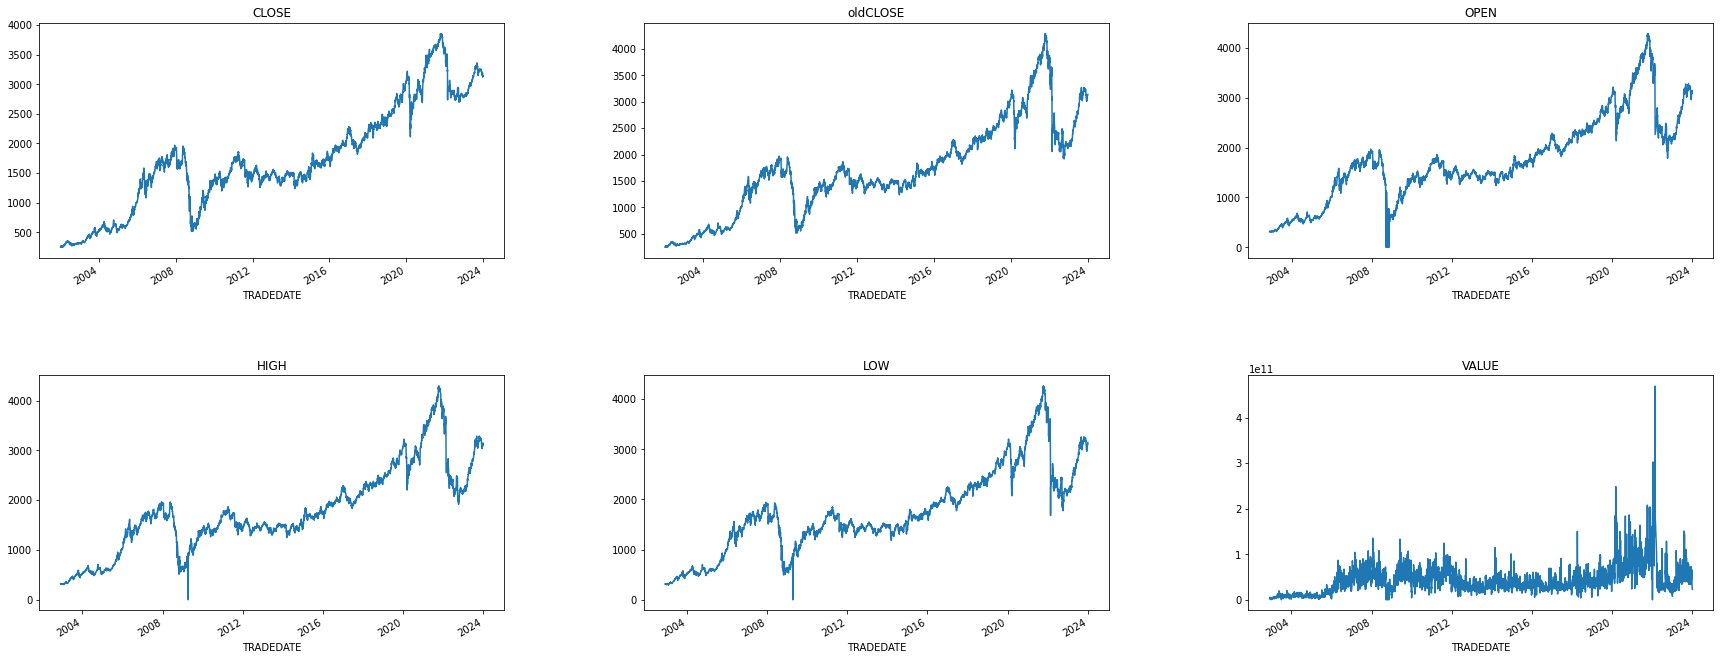

In [441]:
columns_to_plot = ['CLOSE', 'oldCLOSE', 'OPEN', 'HIGH', 'LOW', 'VALUE']

fig, axes = plt.subplots(nrows=len(columns_to_plot)//2-1, ncols=3, figsize=(30, 2 * len(columns_to_plot)))

for i, column in enumerate(columns_to_plot):
    df[column].plot(ax=axes[i//3][i%3], label=column)
    axes[i//3][i%3].set_title(column)
    fig.subplots_adjust(hspace=0.5, wspace=0.3)

plt.show()

<AxesSubplot: xlabel='TRADEDATE'>

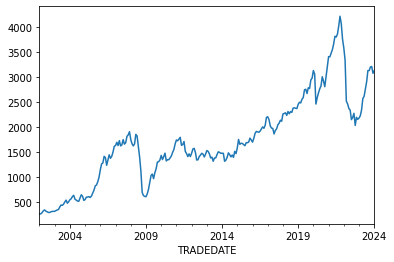

In [481]:
df.oldCLOSE.plot()

<AxesSubplot: xlabel='TRADEDATE'>

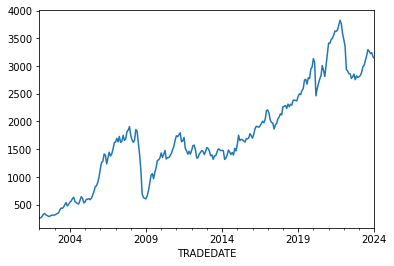

In [480]:
df.CLOSE.plot()

In [482]:
numeric_columns = df.select_dtypes(include=[np.number])
df = numeric_columns.resample('M').mean()
df.head(5)

,CLOSE,OPEN,HIGH,LOW,VALUE,DURATION,YIELD,DECIMALS,DIVISOR,TRADINGSESSION,VOLUME,oldCLOSE
TRADEDATE,,,,,,,,,,,,
2002-01-31,261.968000,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,261.968000
2002-02-28,261.784211,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,261.784211
2002-03-31,285.944500,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,285.944500
2002-04-30,322.336087,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,322.336087
2002-05-31,341.772222,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,341.772222


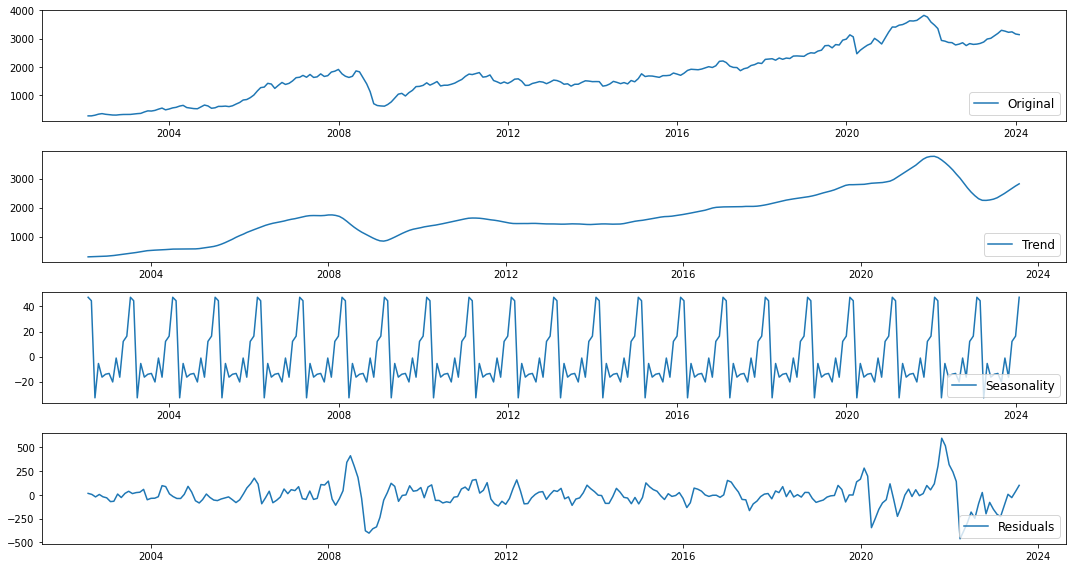

In [570]:
result = seasonal_decompose(df.oldCLOSE, model='additive')

plt.figure(figsize=(15, 8))

plt.subplot(411)
plt.plot(df.CLOSE, label='Original')
plt.legend(loc='lower right', fontsize='large')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='lower right', fontsize='large')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='lower right', fontsize='large')

plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='lower right', fontsize='large')

plt.tight_layout()
plt.show()

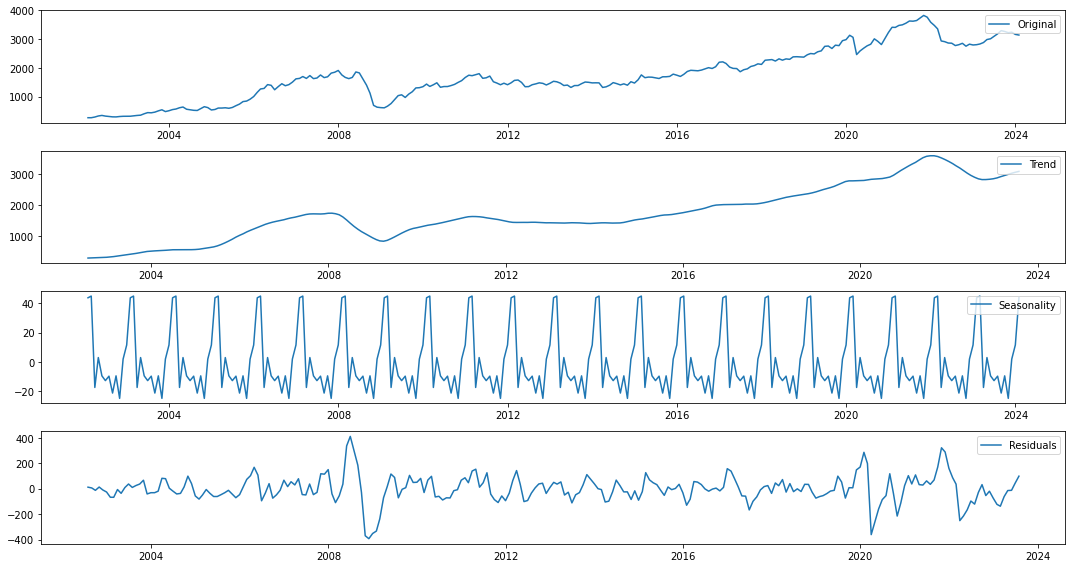

In [484]:
result = seasonal_decompose(df.CLOSE, model='additive')

plt.figure(figsize=(15, 8))

plt.subplot(411)
plt.plot(df.CLOSE, label='Original')
plt.legend(loc='upper right')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper right')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='upper right')

plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Подбор гиперпараметров для модели

In [447]:
# Проверка стационарности временного ряда через критерий Дики-Фуллера
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is the time series stationary?', result[1] < 0.05)

def draw_analysis_plots(column):

    fig = plt.figure(figsize=(30, 5))

    ax1 = fig.add_subplot(131)
    ax1.set_title('1st order differencing')
    ax1.plot(df[column].diff().dropna()) 

    ax2 = fig.add_subplot(132)
    plot_acf(df[column].diff().dropna(), lags=[i for i in range(1, 30)], ax=ax2)
    ax2.set_ylim(-0.5, 0.5)

    ax3 = fig.add_subplot(133)
    plot_pacf(df[column].diff().dropna(), lags=[i for i in range(1, 30)], ax=ax3)
    ax3.set_ylim(-0.5, 0.5)
    plt.show()


ADF Statistic: -12.910894200541907
p-value: 4.0592055607990915e-24
Critical Values: {'1%': -3.4554613060274972, '5%': -2.8725931472675046, '10%': -2.5726600403359887}
Is the time series stationary? True


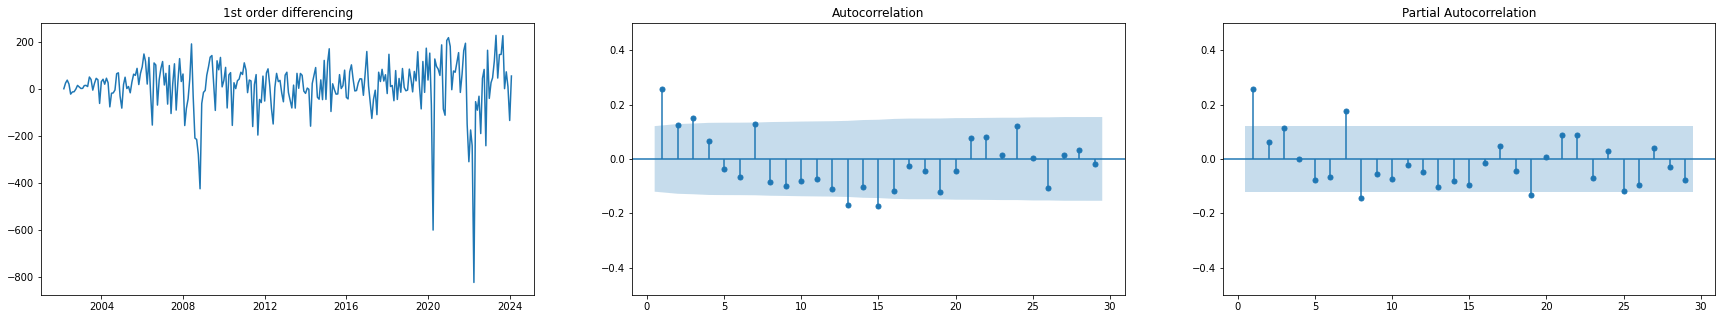

In [448]:
test_stationarity(df.CLOSE.diff().dropna())
draw_analysis_plots("oldCLOSE")

ADF Statistic: -5.420646262796791
p-value: 3.064903387004969e-06
Critical Values: {'1%': -3.4561550092339512, '5%': -2.8728972266578676, '10%': -2.5728222369384763}
Is the time series stationary? True


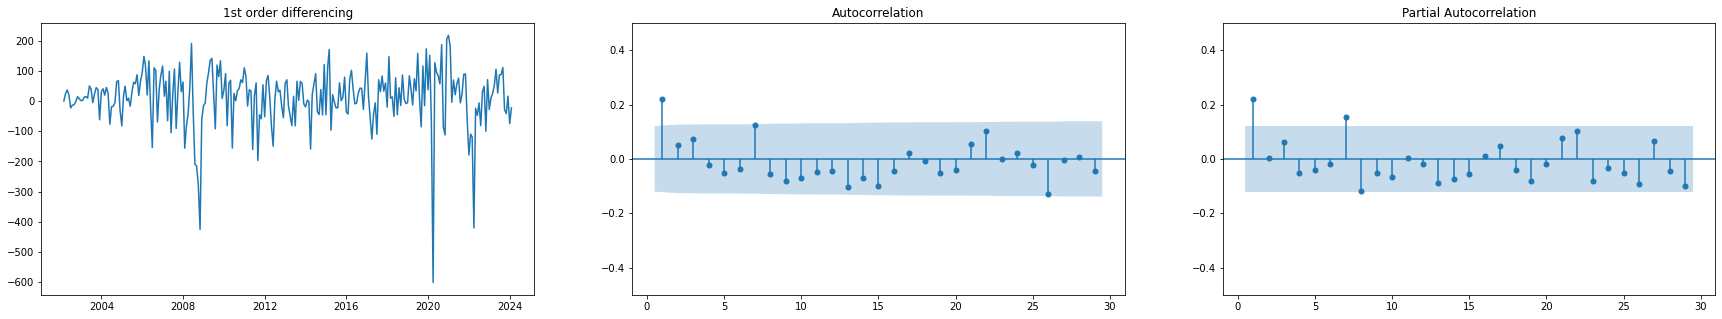

In [449]:
test_stationarity(df.oldCLOSE.diff().dropna())
draw_analysis_plots("CLOSE")

Model 

In [479]:
len(df)

265

Значение p выбирается на основе последней значимой лаги в PACF, в то время как значение q выбирается на основе последней значимой лаги в ACF.

p - количество лагов которые учитываются в регрессии (выбирается по последнему стат значимому значению автокорреляции с PACF)

d - количество дифференцирований для стационарности ряда, которое определяется через критерий Дики Фуллера 

q - количество лагов которые учитываются скользящем окне (выбирается по последнему стат значимому куммулятивному значению авторегрессии с графика ACF) 

In [539]:
months_to_predict = 12  # на сколько месяцев делаются предсказания

p_old = 19              # p для новой стратегии присуждения весов
d_old = 2               # d для новой стратегии присуждения весов
q_old = 3               # q для новой стратегии присуждения весов

p_new = 7               # p для старой стратегии присуждения весов
d_new = 1               # d для старой стратегии присуждения весов
q_new = 26              # q для старой стратегии присуждения весов

In [513]:
# train ARIMA and make predictions
def make_ARIMA_forecast(column, p, d, q, test=1):
    if test: 
        model = ARIMA(df[column][:-months_to_predict], order=(p, d, q)) 
    else:
        model = ARIMA(df[column], order=(p, d, q)) 

    model_fit = model.fit()

    # print(model_fit.summary())

    forecast = model_fit.forecast(steps=months_to_predict) 
    return forecast

In [560]:
# draw a plot with predictions and calcuate metrics
def plot_graphs(forecast, months_to_predict, column, test=1):
    
    # plot
    plt.figure(figsize=(30, 5))

    if test:
        plt.plot(df.index[:-months_to_predict], df[column][:-months_to_predict], label = "Train set", color = "b") 
        plt.plot(df.index[-months_to_predict:], df[column][-months_to_predict:], label = "Test set", color = "g") 
        plt.plot(df.index[-months_to_predict:], forecast, label = "Predictions", color = "r")    
    else:
        plt.plot(df.index, df[column], label = "Train set", color = "b") 
        plt.plot(forecast, label = "Predictions", color = "r")           

    plt.ticklabel_format(axis='y', style='plain')
    plt.grid(True) 
    plt.legend()
    plt.ylabel("IMOEX price")
    years = YearLocator()
    plt.gca().xaxis.set_major_locator(years)
    
    plt.show()
    
    # metrics
    if test:
        actual_data = df[column][-months_to_predict:]
        print("\n---METRICS---\n")
        print("Mean Absolute Error (MAE): ", mean_absolute_error(actual_data, forecast))
        print("R-squared: ", r2_score(actual_data, forecast))
        print("Mean Absolute Percentage Error (MAPE): ", mean_absolute_percentage_error(actual_data, forecast))

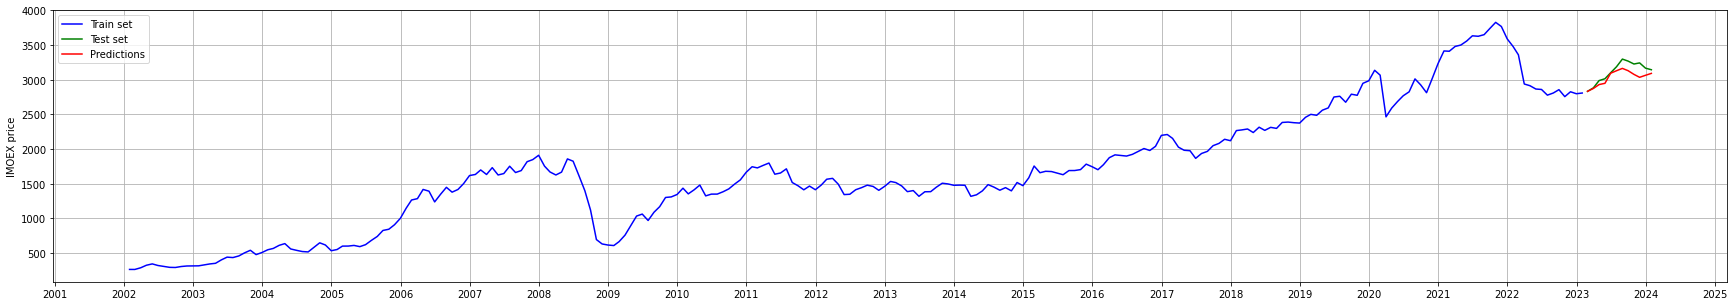


---METRICS---

Mean Absolute Error (MAE):  81.74187876334706
R-squared:  0.5015983616066221
Mean Absolute Percentage Error (MAPE):  0.025581116812461373


In [561]:
new_forecast = make_ARIMA_forecast("CLOSE", p_new, d_new, q_new)
plot_graphs(new_forecast, months_to_predict, "CLOSE")

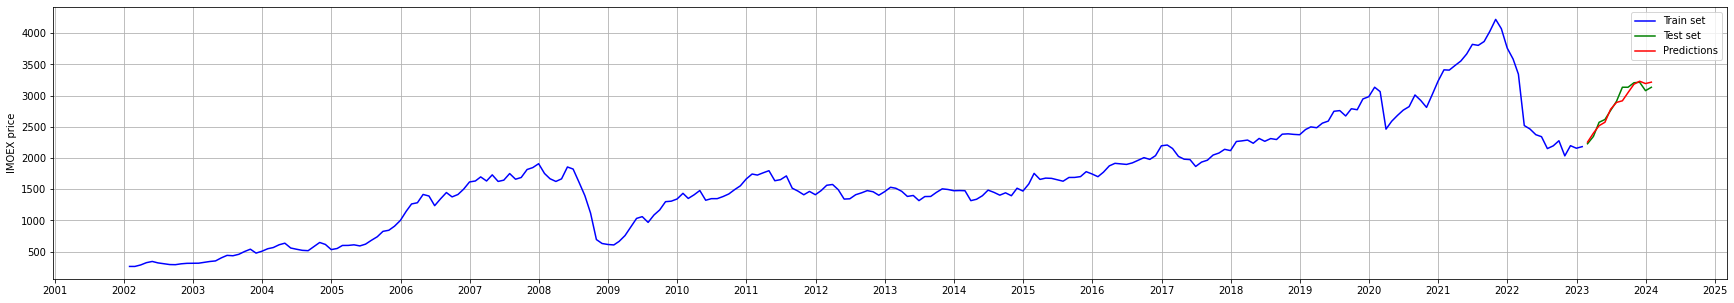


---METRICS---

Mean Absolute Error (MAE):  62.694019542948354
R-squared:  0.937064101612703
Mean Absolute Percentage Error (MAPE):  0.02144421717235231


In [562]:
# обучение и предсказание для тестовой выборки по новой стратегии присуждения весов
old_forecast = make_ARIMA_forecast("oldCLOSE", p_old, d_old, q_old)
plot_graphs(old_forecast, months_to_predict, "oldCLOSE")

Predictions

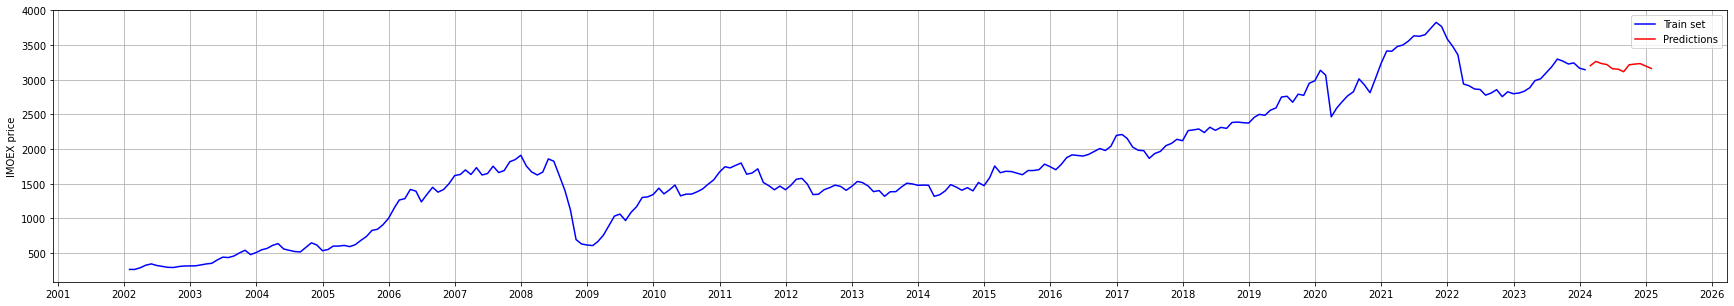

In [563]:
# предсказания для новой статегии присуждения весовых коэфициентов
predictions_new = make_ARIMA_forecast("CLOSE", p_new, d_new, q_new, 0)
plot_graphs(predictions_new, months_to_predict, "CLOSE", 0)

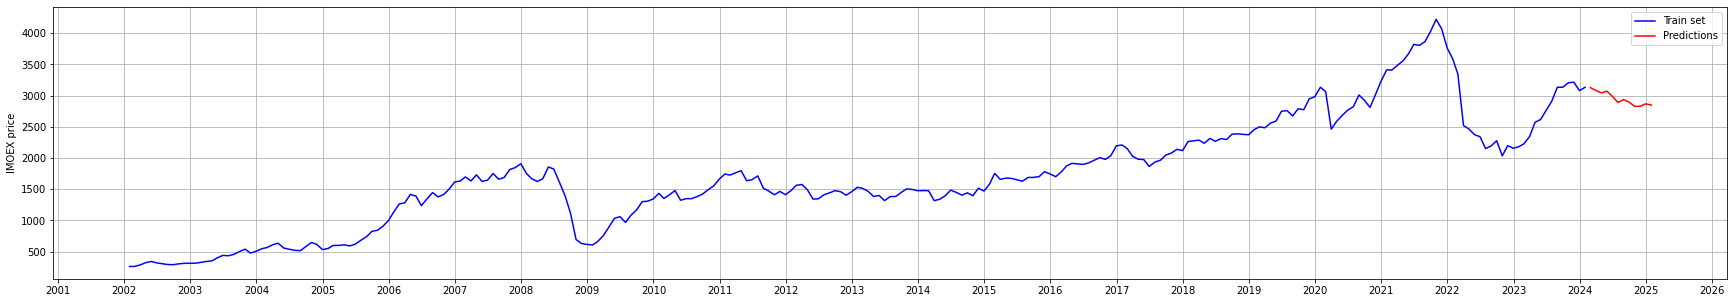

In [564]:
# предсказания для старой статегии присуждения весовых коэфициентов
predictions_old = make_ARIMA_forecast("oldCLOSE", p_old, d_old, q_old, 0)
plot_graphs(predictions_old, months_to_predict, "oldCLOSE", 0)

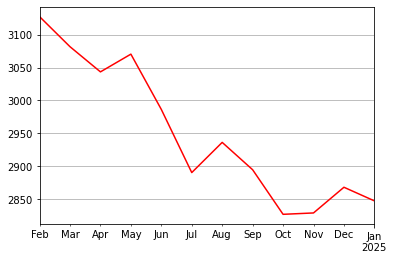

In [549]:
plt.ticklabel_format(useOffset=False)
predictions_old.plot(color='r')
plt.grid(True)
plt.show()

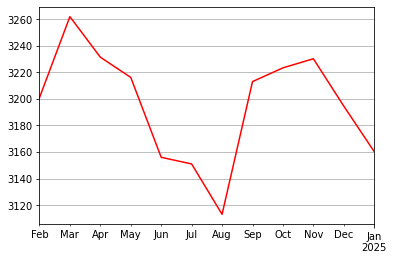

In [547]:
plt.ticklabel_format(useOffset=False)
predictions_new.plot(color='r')
plt.grid(True)
plt.show()

In [521]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


model = LinearRegression()
model.fit(predictions_old.index.values.reshape(-1, 1), predictions_old.values)

predicted_values = model.predict(X)

plt.plot(df['date'], df['predictions_old'], label='Исходные значения')
plt.plot(df['date'], predicted_values, label='Предсказанные значения')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

coefficient = model.coef_[0]
print('Коэффициент зависимой переменной:', coefficient)

TypeError: The DType <class 'numpy.dtype[datetime64]'> could not be promoted by <class 'numpy.dtype[float64]'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtype[datetime64]'>, <class 'numpy.dtype[float64]'>)

Дополнение

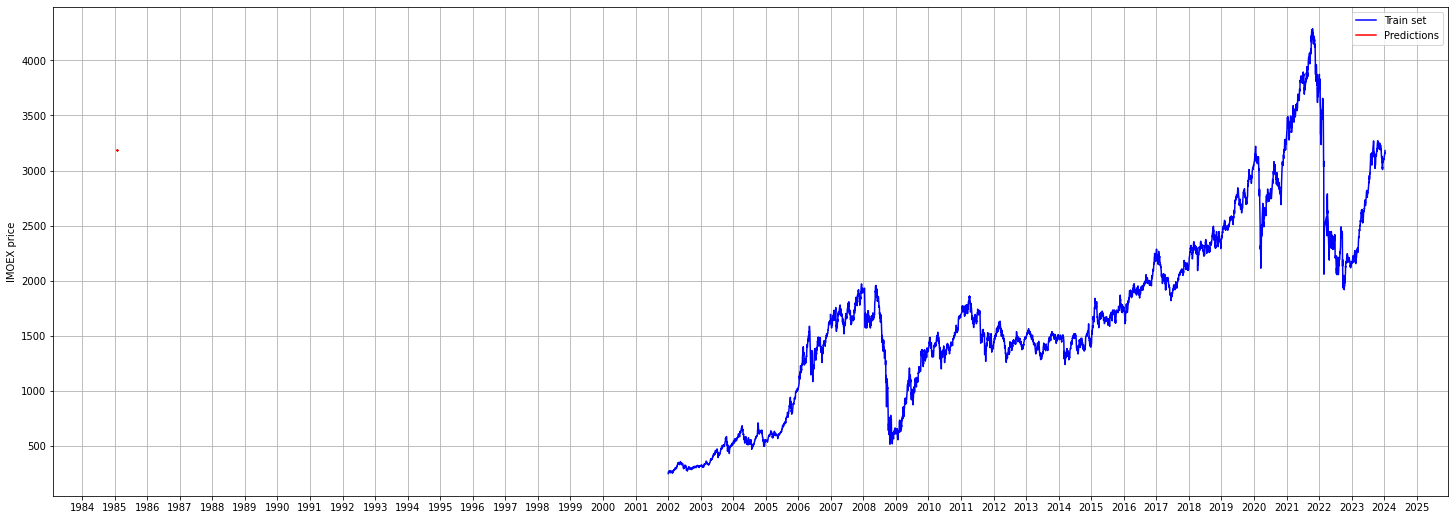


---METRICS---

Mean Absolute Error (MAE):  52.36686142081843
R-squared:  -3.1874971248697976
Mean Absolute Percentage Error (MAPE):  0.016823021895607183


In [177]:
def plot_graphs(forecast, months_to_predict):
    # plot
    plt.figure(figsize=(25, 9))

    plt.plot(df.index, df.CLOSE, label = "Train set", color = "b") 
    plt.plot(forecast, label = "Predictions", color = "r")    

    plt.ticklabel_format(axis='y', style='plain')
    plt.grid(True) 
    plt.legend()
    plt.ylabel("IMOEX price")
    years = YearLocator()
    plt.gca().xaxis.set_major_locator(years)
    
    plt.show()
    
    # metrics
    actual_data = df.CLOSE[-months_to_predict:]
    print("\n---METRICS---\n")
    print("Mean Absolute Error (MAE): ", mean_absolute_error(actual_data, forecast))
    print("R-squared: ", r2_score(actual_data, forecast))
    print("Mean Absolute Percentage Error (MAPE): ", mean_absolute_percentage_error(actual_data, forecast))

plot_graphs(forecast, months_to_predict)

<AxesSubplot: xlabel='TRADEDATE'>

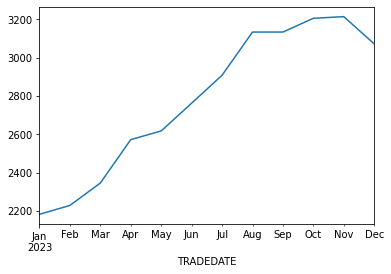

In [55]:
df.CLOSE[-months_to_predict:].plot()

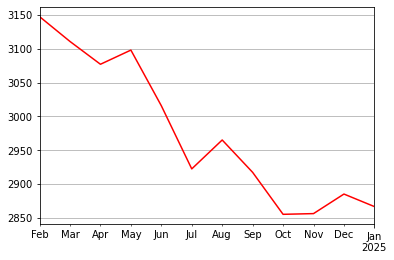

In [33]:
plt.ticklabel_format(useOffset=False)
forecast.plot(color='r')
plt.grid(True)
plt.show()